# 4 解码器

-结构
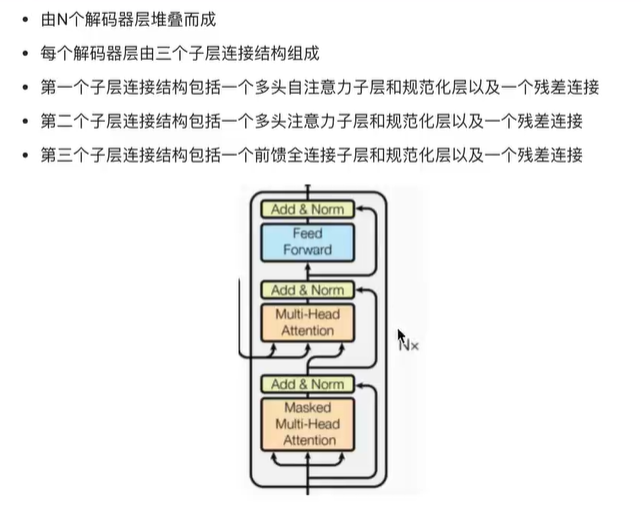

- 代码实现

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from torch.autograd import Variable

In [ ]:
# 使用DecoderLayer的类实现解码器层
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        '''参数有5个：
        size：词嵌入的维度，也是解码器尺寸，==d_model
        self_attn：多头自注意力对象,Q=K=V
        src_attn：多头注意力对象,Q!=K=V
        feed_forward：前馈神经网络对象
        dropout：dropout层的对象'''
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        # 按照结构图使用clones函数克隆三个子层连接对象
        # SublayerConnection: norm+残差连接
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        
    def forward(self, x, memory, source_mask, target_mask):
        '''参数有4个：
        x：目标数据张量
        memory：来自编码器层的语义存储变量
        source_mask：源数据掩码张量
        target_mask：目标数据掩码张量'''
        # 将memory表示成m方便之后使用
        m = memory
        # 将x传入第一个子层结构，计算自注意力，第一个子层结构的输入分别是x和self-attn函数
        # 最后一个参数是目标数据掩码张量，这时要对目标数据进行遮掩，因为此时模型可能还没有生成任何字符或词汇
        # 比如在解码器准备生成第二个字符时，模型只能使用第一个字符或词汇信息，第二个字符以及之后的信息都不允许被模型使用
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, target_mask))
        # 将x传入第二个子层结构，第二个子层结构的输入分别是x和src-attn函数
        # 这里Q!=K=V，即查询不等于键等于值
        # q=x,k=m,v=m,即用编码器的输出作为键和值，而用x作为查询
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, source_mask))
        # 最后一层是前馈全连接子层
        x = self.sublayer[2](x, self.feed_forward)
        return x


- 简单演示

In [ ]:
head = 8
size = 512
d_model = 512
d_ff = 64
dropout = 0.2
# 注意力机制
self_attn = src_attn = MultiHeadedAttention(head, d_model, dropout)
# 前馈全连接层也和之前相同
feed_forward = PositionalwiseFeedForward(d_model, d_ff, dropout)


In [ ]:
#x是来自目标数据的词嵌入表示，但形式和源数据的词嵌入表示相同
output_x= pe_result
# memory是来自编码器的输出
memory = encorder_result

# 实际中source_mask和target_mask并不相同,这里为了方便计算使他们都为mask
mask = Variable(torch.zeros(8,4,4))
source_mask = target_mask = mask

# 调用
decoder_layer = DecoderLayer(size, self_attn, src_attn, feed_forward, dropout)
decorder_result = decoder_layer(output_x, memory, source_mask, target_mask)


# 4.2 N个解码器

- 作用

根据编码器的结果以及上一次预测的结构，对下一次可能出现的'值'进行特征表示

- 代码实现

In [ ]:
# 使用类Decoder来实现解码器
class Decoder(nn.Module):
    def __init__(self, layer, N):
        """初始化函数的参数有两个，第一个就是解码器层layer，第二个是解码器层的个数N."""
        super(Decoder, self).__init__()
        # 首先使用clones方法克隆了N个layer，然后实例化了一个规范化层。
        # 因为数据走过了所有的解码器层后最后要做规范化处理，
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, source_mask, target_mask):
        """forward函数中的参数有4个，x代表目标数据的嵌入表示，memory是编码器层的输出，
        source_mask，target_mask代表源数据和目标数据的掩码张量"""
        # 然后就是对每个层进行循环，当然这个循环就是变量x通过每一个层的处理
        # 得出最后的结果，再进行一次规范化返回即可
        for layer in self.layers:
            x = layer(x, memory, source_mask, target_mask)
        return self.norm(x)


In [ ]:
# 实例化参数
# 分别是解码器层layer和解码器层的个数N
size = 512
d_model = 512
head = 8
d_ff = 64
dropout = 0.2
c = copy.deepcopy
attn = MultiHeadedAttention(head, d_model, dropout)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
layer = DecoderLayer(size, c(attn), c(attn), c(ff), dropout)
N = 8

# 输入参数:
# 输入参数与解码器层的输入参数相同
X = pe_result
memory = en_result
mask = Variable(torch.zeros(8, 4, 4))
source_mask = target_mask = mask

decoder = Decoder(layer, N)
output = decoder(X, memory, source_mask, target_mask)
